In [1]:
import pandas as pd
import numpy as np
from vininfo import Vin
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, TargetEncoder
import torch as T
import torch.nn as nn
from torch.utils.data import Dataset
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from tqdm import tqdm

pd.options.mode.chained_assignment = None
import warnings
warnings.filterwarnings("ignore")

In [2]:
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')

In [3]:
train_df.info()
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          440236 non-null  int64  
 1   make          432193 non-null  object 
 2   model         432113 non-null  object 
 3   trim          431899 non-null  object 
 4   body          429843 non-null  object 
 5   transmission  388775 non-null  object 
 6   vin           440236 non-null  object 
 7   state         440236 non-null  object 
 8   condition     430831 non-null  float64
 9   odometer      440167 non-null  float64
 10  color         439650 non-null  object 
 11  interior      439650 non-null  object 
 12  seller        440236 non-null  object 
 13  sellingprice  440236 non-null  int64  
 14  saledate      440236 non-null  object 
dtypes: float64(2), int64(2), object(11)
memory usage: 50.4+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110058 entries, 0 to 110057

In [4]:
print(100*(train_df.isnull().sum()/len(train_df)).sort_values(ascending=False))
print('--------------------------')
print(100*(test_df.isnull().sum()/len(train_df)).sort_values(ascending=False))

transmission    11.689412
body             2.360779
condition        2.136354
trim             1.893757
model            1.845147
make             1.826975
color            0.133110
interior         0.133110
odometer         0.015673
year             0.000000
vin              0.000000
state            0.000000
seller           0.000000
sellingprice     0.000000
saledate         0.000000
dtype: float64
--------------------------
transmission    2.955460
body            0.589229
condition       0.540392
trim            0.480197
model           0.472247
make            0.468158
color           0.035890
interior        0.035890
odometer        0.004316
year            0.000000
vin             0.000000
state           0.000000
seller          0.000000
saledate        0.000000
dtype: float64


Посмотрим, есть ли явные дубликаты

In [5]:
train_df.duplicated().sum()

0

С помощью vin заполним пропуски и избавимся от неявных дубликатов в колонке make с информацией о марке авто, а также - обработаем неявные дубликаты.

In [6]:
#
def model_parsing(s):
    vn = Vin(s['vin'].upper())
    vin_make = vn.annotate()['Manufacturer'].lower()
    df_make = str(s['make']).lower()
    if len(vin_make) > len(df_make) and df_make != 'nan':
        return df_make
    else:
        return vin_make

    
train_df['make'] = train_df.apply(model_parsing, axis=1)

In [7]:
train_df.groupby('make')['state'].count().describe()

count       77.000000
mean      5717.350649
std      12515.808225
min          1.000000
25%         19.000000
50%        809.000000
75%       4670.000000
max      75300.000000
Name: state, dtype: float64

In [8]:
few = []
more = []

In [9]:
train_df.groupby('make')['state'].count().sort_values().head(25)

make
dot                                1
airstream                          1
volkswagen commercial vehicles     1
bmw m                              1
porsche suv                        1
daewoo                             1
mercedes-b                         2
am                                 3
mercedes-benz (sprinter)           4
unsupportedbrand                   4
lamborghini                        4
fisker                             7
daimler ag (sprinter)              9
rolls royce                       14
geo                               16
tesla                             17
ferrari                           18
vw                                18
landrover                         19
daimlerchrysler ag/daimler ag     19
gmc truck                         20
aston martin                      23
chevrolet canada                  39
plymouth                          41
mercedes                          61
Name: state, dtype: int64

In [10]:
for brand, count in train_df.groupby('make')['state'].count().to_dict().items():
    if count < 10: few.append(brand)
    else: more.append(brand)
print(sorted(few))
print(sorted(more))

['airstream', 'am', 'bmw m', 'daewoo', 'daimler ag (sprinter)', 'dot', 'fisker', 'lamborghini', 'mercedes-b', 'mercedes-benz (sprinter)', 'porsche suv', 'unsupportedbrand', 'volkswagen commercial vehicles']
['acura', 'aston martin', 'audi', 'bentley', 'bmw', 'buick', 'cadillac', 'cami', 'chevrolet', 'chevrolet canada', 'chevrolet mexico', 'chevrolet usa', 'chrysler', 'chrysler canada', 'daimlerchrysler ag/daimler ag', 'dodge', 'dodge canada', 'dodge mexico', 'ferrari', 'fiat', 'ford', 'genesis', 'geo', 'gmc', 'gmc truck', 'honda', 'hummer', 'hyundai', 'infiniti', 'isuzu', 'jaguar', 'jeep', 'kia', 'land rover', 'landrover', 'lexus', 'lincoln', 'maserati', 'mazda', 'mercedes', 'mercedes-benz', 'mercury', 'mini', 'mitsubishi', 'nissan', 'nummi', 'oldsmobile', 'plymouth', 'pontiac', 'porsche', 'porsche car', 'ram', 'rolls royce', 'saab', 'saturn', 'scion', 'smart', 'subaru', 'suzuki', 'tesla', 'toyota', 'volkswagen', 'volvo', 'vw']


In [11]:
def cut_brands(m):
    for r_m in more:
        if m == ''.join(str(l[0]) for l in r_m.split(' ')) or m == r_m[0]+r_m[len(r_m)//2] or r_m in m or m == r_m.replace(' ', ''):
            return r_m
    if m in few:
        return None

In [12]:
train_df['make_filtered'] = train_df['make'].apply(cut_brands)

In [13]:
train_df['make_filtered'].unique()

array(['ford', 'nissan', 'hummer', 'lincoln', 'pontiac', 'genesis',
       'toyota', 'buick', 'chevrolet', 'honda', 'acura', 'cadillac',
       'gmc', 'saab', 'dodge', 'mercedes', 'volkswagen', 'mazda', 'bmw',
       'chrysler', 'hyundai', 'kia', 'jaguar', 'subaru', 'jeep', 'lexus',
       'scion', 'fiat', 'suzuki', 'land rover', 'volvo', 'audi', 'nummi',
       'cami', 'infiniti', 'mini', 'isuzu', 'mitsubishi', 'smart',
       'porsche', 'saturn', 'ram', 'oldsmobile', 'mercury', 'bentley',
       None, 'maserati', 'tesla', 'aston martin', 'rolls royce',
       'ferrari', 'plymouth', 'geo'], dtype=object)

In [14]:
len(train_df['make_filtered'].unique())

53

In [15]:
len(train_df['make'].unique())

77

In [16]:
train_df = train_df.dropna(subset=['make_filtered'])

In [17]:
len(train_df['make_filtered'].unique())

52

In [18]:
train_df['make'] = train_df['make_filtered']
train_df = train_df.drop(columns='make_filtered')

Теперь в датасете осталась информация о 52 брендах.

In [19]:
len(train_df['model'].unique())

956

In [20]:
train_df.groupby('model')['state'].count().sort_values().head(20).to_dict() # преобразуем в словарь, чтобы увидеть пропуски в конце (в данном случае их нет)

{'Corsica': 1,
 'b2300': 1,
 'B-Series': 1,
 'aveo': 1,
 'avenger': 1,
 'pt': 1,
 'pursuit': 1,
 'avalon': 1,
 'alp': 1,
 'a6': 1,
 'ram3500': 1,
 'Equator': 1,
 'Tempo': 1,
 'Aspire': 1,
 'rio': 1,
 'f350': 1,
 'rrs': 1,
 'Spirit': 1,
 'ActiveHybrid 5': 1,
 'Sierra 1500 Hybrid': 1}

In [21]:
def strp(r):
    return str(r).strip()

In [22]:
train_df['model_striped'] = train_df['model'].apply(strp)

In [23]:
len(train_df['model_striped'].unique())

956

In [24]:
train_df = train_df.drop(columns='model_striped')

In [25]:
100*(train_df.isnull().sum()/len(train_df)).sort_values(ascending=False)

transmission    11.689902
body             2.357517
condition        2.136485
trim             1.890693
model            1.842307
color            0.133119
interior         0.133119
odometer         0.015674
year             0.000000
make             0.000000
vin              0.000000
state            0.000000
seller           0.000000
sellingprice     0.000000
saledate         0.000000
dtype: float64

Посмотрим, как распределены данные с пропусками.

<Axes: >

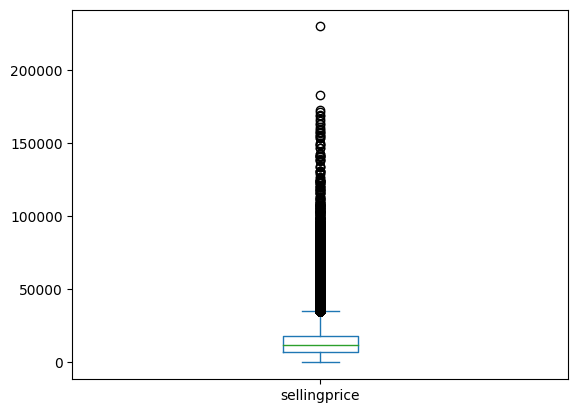

In [26]:
train_df['sellingprice'].plot(kind='box')

In [27]:
train_df['sellingprice'].describe()

count    440209.000000
mean      13590.399856
std        9745.050311
min           1.000000
25%        6900.000000
50%       12100.000000
75%       18200.000000
max      230000.000000
Name: sellingprice, dtype: float64

In [28]:
train_df[train_df['odometer'].isnull()].describe()

,year,condition,odometer,sellingprice
count,69.000000,20.000000,0.0,69.000000
mean,2003.913043,2.570000,NaN,4899.434783
std,4.477851,1.054863,NaN,7724.674869
min,1995.000000,1.000000,NaN,1.000000
25%,2001.000000,1.900000,NaN,500.000000
50%,2003.000000,2.100000,NaN,1200.000000
75%,2006.000000,3.250000,NaN,4700.000000
max,2014.000000,4.600000,NaN,35000.000000


Для заполнения пропусков в колонках transmission, body и condition построим модели.

In [31]:
oe_features = train_df.select_dtypes(include='object').columns.to_list()
num_features = train_df.select_dtypes(exclude='object').columns.to_list()

In [32]:
oe_features

['make',
 'model',
 'trim',
 'body',
 'transmission',
 'vin',
 'state',
 'color',
 'interior',
 'seller',
 'saledate']

In [33]:
train_df['body'].unique()

array(['suv', 'Sedan', 'sedan', nan, 'SUV', 'wagon', 'Minivan',
       'Extended Cab', 'Regular Cab', 'Coupe', 'SuperCrew', 'Wagon',
       'convertible', 'Crew Cab', 'SuperCab', 'Convertible', 'Hatchback',
       'minivan', 'hatchback', 'G Coupe', 'G Convertible', 'coupe',
       'Access Cab', 'G Sedan', 'regular cab', 'e-series van',
       'supercrew', 'Quad Cab', 'tsx sport wagon', 'Van', 'g sedan',
       'E-Series Van', 'CTS Coupe', 'Koup', 'King Cab', 'extended cab',
       'double cab', 'Elantra Coupe', 'koup', 'access cab', 'Double Cab',
       'crew cab', 'quad cab', 'g coupe', 'CrewMax Cab', 'supercab',
       'g convertible', 'Genesis Coupe', 'van', 'G37 Coupe', 'club cab',
       'Beetle Convertible', 'Mega Cab', 'regular-cab', 'Xtracab',
       'cts coupe', 'genesis coupe', 'Club Cab', 'q60 coupe', 'mega cab',
       'crewmax cab', 'Promaster Cargo Van', 'king cab', 'CTS-V Coupe',
       'TSX Sport Wagon', 'CTS Wagon', 'Cab Plus 4', 'G37 Convertible',
       'Transit Van'

In [34]:
num_features

['year', 'condition', 'odometer', 'sellingprice']

In [35]:
def less_classes(c, d, param):
    m = c[param]
    if d[str(m)] < 50:
        return 'other'
    else:
        return str(m)


In [36]:
train_df['model'] = train_df.apply(func=less_classes, axis=1, param='model', d=dict(train_df['model'].astype('str').value_counts()))

In [37]:
train_df['trim'] = train_df.apply(func=less_classes, axis=1, param='trim', d=dict(train_df['trim'].astype('str').value_counts()))

In [ ]:
train_df['seller'] = train_df.apply(func=less_classes, axis=1, param='seller', d=dict(train_df['seller'].astype('str').value_counts()))

In [ ]:
train_df.columns

### Fill transmission

In [ ]:
import gc
gc.collect()
df = train_df.drop(columns=['vin'])
# кодирование данных
train_ftrs = df.dropna(subset=['transmission'])
train_ftrs_no_trnsm = train_ftrs.drop(columns=['transmission'])
fill_ftrs = df[df['transmission'].isna()].drop(columns=['transmission'])

ftrs = pd.concat([train_ftrs_no_trnsm, fill_ftrs])
train_trnsm_target = train_ftrs['transmission']

ftrs_ohe = pd.get_dummies(ftrs, drop_first=True)

train_ftrs_ohe = ftrs_ohe[:len(train_ftrs)]
fill_ftrs_ohe = ftrs_ohe[len(train_ftrs):]

In [ ]:
model = CatBoostClassifier(iterations=1000,
                           task_type="GPU",
                           devices='0')


model.fit(train_ftrs_ohe,
          train_trnsm_target,
          verbose=False)

In [ ]:
from tqdm import tqdm
from tqdm.gui import tqdm as tqdm_gui
tqdm.pandas(ncols=50)

def fill_transmission(s, ohe):
    if s.values[0] not in ['automatic', 'manual']:
        ohe_sample = ohe.loc[[s.name]]
        t = model.predict(ohe_sample, task_type='GPU')
        # print('0', t[0])
        return t[0]
    else:
        # print('1', s.values[0])
        return s.values[0]

train_df['transmission_'] = train_df[['transmission']].progress_apply(fill_transmission, ohe=fill_ftrs_ohe, axis=1)
# data = pd.get_dummies(train_df.drop(columns=['transmission', 'vin']), drop_first=True)
# train_df['transmission'].fillna(model.predict(data.to('cuda')))

In [ ]:
# import os  

# os.makedirs('./DATA', exist_ok=True)  

# train_df.to_csv('./DATA/data.csv')

In [ ]:
train_df = pd.read_csv('./DATA/data.csv')
test_df = pd.read_csv('./test.csv')

In [ ]:
train_df['transmission_'].unique()

In [ ]:
body_uniq = train_df['body'].unique()

### Fill body

In [ ]:
import gc
gc.collect()
df = train_df.drop(columns=['vin'])
# кодирование данных
train_ftrs = df.dropna(subset=['body'])
train_ftrs_no_trnsm = train_ftrs.drop(columns=['body'])
fill_ftrs = df[df['body'].isna()].drop(columns=['body'])

ftrs = pd.concat([train_ftrs_no_trnsm, fill_ftrs])
train_trnsm_target = train_ftrs['body']

ftrs_ohe = pd.get_dummies(ftrs, drop_first=True)

train_ftrs_ohe = ftrs_ohe[:len(train_ftrs)]
fill_ftrs_ohe = ftrs_ohe[len(train_ftrs):]

In [ ]:
model = CatBoostClassifier(iterations=1000,
                           task_type="GPU",
                           devices='0')


model.fit(train_ftrs_ohe,
          train_trnsm_target,
          verbose=False)

In [ ]:
from tqdm import tqdm
from tqdm.gui import tqdm as tqdm_gui
tqdm.pandas(ncols=50)

def fill_body(s, ohe, body_uniq):
    if s.values[0] not in body_uniq:
        ohe_sample = ohe.loc[[s.name]]
        t = model.predict(ohe_sample)#, task_type='GPU')
        # print('0', t[0][0])
        return t[0][0]
    else:
        # print('1', s.values[0])
        return s.values[0]

train_df['body_'] = train_df[['body']].progress_apply(fill_body, ohe=fill_ftrs_ohe, body_uniq=body_uniq, axis=1)
# data = pd.get_dummies(train_df.drop(columns=['transmission', 'vin']), drop_first=True)
# train_df['transmission'].fillna(model.predict(data.to('cuda')))

In [ ]:
# import os  

# os.makedirs('./DATA', exist_ok=True)  

# train_df.to_csv('./DATA/data2.csv')

In [ ]:
train_df = train_df.drop(columns=['body', 'transmission'])


In [ ]:
train_df.rename(columns={"body_": "body", "transmission_": "transmission"}, inplace=True)

In [ ]:
print(100*(train_df.isnull().sum()/len(train_df)).sort_values(ascending=False))

### Fill condition

In [ ]:
import gc
gc.collect()
df = train_df.drop(columns=['vin'])
# кодирование данных
train_ftrs = df.dropna(subset=['condition'])
train_ftrs_no_trnsm = train_ftrs.drop(columns=['condition'])
fill_ftrs = df[df['condition'].isna()].drop(columns=['condition'])

ftrs = pd.concat([train_ftrs_no_trnsm, fill_ftrs])
train_trnsm_target = train_ftrs['condition']

ftrs_ohe = pd.get_dummies(ftrs, drop_first=True)

train_ftrs_ohe = ftrs_ohe[:len(train_ftrs)]
fill_ftrs_ohe = ftrs_ohe[len(train_ftrs):]

In [ ]:
model = CatBoostClassifier(iterations=1000,
                           task_type="GPU",
                           devices='0')


model.fit(train_ftrs_ohe,
          train_trnsm_target,
          verbose=False)

In [ ]:
condition_uniq = train_df['condition'].dropna().unique()

In [ ]:
from tqdm import tqdm
from tqdm.gui import tqdm as tqdm_gui
tqdm.pandas(ncols=50)

def fill_condition(s, ohe, condition_uniq):
    if s.values[0] not in condition_uniq:
        ohe_sample = ohe.loc[[s.name]]
        t = model.predict(ohe_sample)#, task_type='GPU')
        # print('0', round(t[0][0], 1))
        return round(t[0][0], 1)
    else:
        # print('1', s.values[0])
        return s.values[0]

train_df['condition_'] = train_df[['condition']].progress_apply(fill_condition, ohe=fill_ftrs_ohe, condition_uniq=condition_uniq, axis=1)

In [ ]:
train_df = train_df.drop(columns=['condition'])
train_df.rename(columns={"condition.1": "condition"}, inplace=True)

In [ ]:
# os.makedirs('./DATA', exist_ok=True)  

# train_df.to_csv('./DATA/data4.csv')

In [ ]:
100*(train_df.isnull().sum()/len(train_df)).sort_values(ascending=False)

### Fill interior

In [ ]:
train_df = pd.read_csv('./DATA/data4.csv')

In [ ]:
import gc
gc.collect()
df = train_df.drop(columns=['vin'])
# кодирование данных
train_ftrs = df.dropna(subset=['interior'])
train_ftrs = train_ftrs.loc[train_ftrs['interior'] != '—']
train_ftrs_no_trnsm = train_ftrs.drop(columns=['interior'])
fill_ftrs = df.loc[(df['interior'].isna()) | (df['interior'] == '—')].drop(columns=['interior'])

ftrs = pd.concat([train_ftrs_no_trnsm, fill_ftrs])
train_trnsm_target = train_ftrs['interior']

ftrs_ohe = pd.get_dummies(ftrs, drop_first=True)

train_ftrs_ohe = ftrs_ohe[:len(train_ftrs)]
fill_ftrs_ohe = ftrs_ohe[len(train_ftrs):]

In [ ]:
model = CatBoostClassifier(iterations=1000,
                           task_type="GPU",
                           devices='0')


model.fit(train_ftrs_ohe,
          train_trnsm_target,
          verbose=False)

In [ ]:
interior_uniq = train_df['interior'].dropna().unique()

In [ ]:
interior_uniq = interior_uniq[interior_uniq != '—']

In [ ]:
interior_uniq

In [ ]:
fill_ftrs_ohe.head()

In [ ]:
from tqdm import tqdm
from tqdm.gui import tqdm as tqdm_gui
tqdm.pandas(ncols=50)

def fill_interior(s, ohe, interior_uniq):
    if s.values[0] not in interior_uniq:
        idx = [s.name][0]
        # try:
        ohe_sample = ohe.loc[idx]
        t = model.predict(ohe_sample) #, task_type='GPU')
        # print('0', t[0])
        return t[0]
        # except:
        #     print(idx)
    else:
        # print('1', s.values[0])
        return s.values[0]

train_df['interior_'] = train_df[['interior']].progress_apply(fill_interior, ohe=fill_ftrs_ohe, interior_uniq=interior_uniq, axis=1)

In [ ]:
train_df['interior_'].unique()

In [ ]:
train_df['interior'] = train_df['interior_']

In [ ]:
train_df = train_df.drop(columns=['interior_'])

In [ ]:
# import os
# os.makedirs('./DATA', exist_ok=True)  
# train_df.to_csv('./DATA/data5.csv')

### Fill color

In [ ]:
train_df['color'].unique()

In [ ]:
import gc
gc.collect()
df = train_df.drop(columns=['vin'])
# кодирование данных
train_ftrs = df.dropna(subset=['color'])
train_ftrs = train_ftrs.loc[train_ftrs['color'] != '—']
train_ftrs_no_trnsm = train_ftrs.drop(columns=['color'])
fill_ftrs = df.loc[(df['color'].isna()) | (df['color'] == '—')].drop(columns=['color'])

ftrs = pd.concat([train_ftrs_no_trnsm, fill_ftrs])
train_trnsm_target = train_ftrs['color']

ftrs_ohe = pd.get_dummies(ftrs, drop_first=True)

train_ftrs_ohe = ftrs_ohe[:len(train_ftrs)]
fill_ftrs_ohe = ftrs_ohe[len(train_ftrs):]

In [ ]:
model = CatBoostClassifier(iterations=1000,
                           task_type="GPU",
                           devices='0')


model.fit(train_ftrs_ohe,
          train_trnsm_target,
          verbose=False)

In [ ]:
color_uniq = train_df['color'].dropna().unique()

In [ ]:
color_uniq = color_uniq[color_uniq != '—']

In [ ]:
color_uniq

In [ ]:
from tqdm import tqdm
from tqdm.gui import tqdm as tqdm_gui
tqdm.pandas(ncols=50)

def fill_color(s, ohe, color_uniq):
    if s.values[0] not in color_uniq:
        idx = [s.name][0]
        # try:
        ohe_sample = ohe.loc[idx]
        t = model.predict(ohe_sample) #, task_type='GPU')
        # print('0', t[0])
        return t[0]
        # except:
        #     print(idx)
    else:
        # print('1', s.values[0])
        return s.values[0]

train_df['color_'] = train_df[['color']].progress_apply(fill_color, ohe=fill_ftrs_ohe, color_uniq=color_uniq, axis=1)

In [ ]:
train_df['color_'].unique()

In [ ]:
train_df['color'] = train_df['color_']

In [ ]:
train_df = train_df.drop(columns=['color_'])

In [ ]:
# os.makedirs('./DATA', exist_ok=True)  
# train_df.to_csv('./DATA/data6.csv')

### Кодируем данные и обучаем нейросетевую модель

In [3]:
train_df_ = pd.read_csv('./data6.csv')

In [4]:
train_df_ = train_df_.dropna(subset=['odometer'])

In [5]:
import gc
gc.collect()
# кодирование данных
train_ftrs = train_df_.drop(columns=['sellingprice'])
train_target = train_df_['sellingprice']
test_ftrs = test_df

In [6]:
train_ftrs = train_ftrs.drop(columns=['Unnamed: 0.3', 'Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0'])
# train_ftrs['vin'] = train_ftrs['vin'].astype("string")
# test_ftrs['vin'] = test_ftrs['vin'].astype("string")

In [7]:
oe_features = test_ftrs.select_dtypes(include='object').columns.to_list()
print(oe_features)

num_features = test_ftrs.select_dtypes(exclude='object').columns.to_list()
print(num_features)

['make', 'model', 'trim', 'body', 'transmission', 'vin', 'state', 'color', 'interior', 'seller', 'saledate']
['year', 'condition', 'odometer']


In [8]:
# train_ftrs['saledate'] = pd.to_datetime(train_ftrs['saledate'])

In [9]:
ord_enc = TargetEncoder(target_type='continuous')

test_ftrs[oe_features] = test_ftrs[oe_features].astype('str')

ord_enc.fit(train_ftrs[oe_features], train_target)

train_ftrs[
    ord_enc.get_feature_names_out()
] = ord_enc.transform(train_ftrs[oe_features])

scaler = StandardScaler()

train_ftrs[num_features] = scaler.fit_transform(train_ftrs[num_features])

train_ftrs.head()

,year,make,model,trim,vin,state,odometer,color,interior,seller,saledate,transmission,body,condition
0,0.241104,14330.110721,18820.192836,14299.814159,12500.0,7451.402171,0.797425,15937.819638,15699.318277,7904.551314,12786.384043,13666.233544,16350.222382,0.829916
1,0.995445,14330.110721,12363.739115,11221.886419,14500.0,14460.621405,-0.696870,15937.819638,15699.318277,18163.529974,15260.335085,13666.233544,11597.344262,0.101571
2,0.492551,13821.337654,8743.164610,8540.426190,9100.0,13630.868545,-0.611235,15937.819638,15699.318277,13808.317065,13089.808093,13666.233544,12661.809255,-1.251071
3,-1.770471,15187.838135,18499.897110,13827.544599,13300.0,13159.907150,1.175822,8267.331053,13255.691495,16436.773787,15369.754325,13666.233544,16350.222382,-0.626775
4,-0.764683,14330.110721,12363.739115,14299.814159,1300.0,7451.402171,1.108734,15937.819638,15699.318277,904.942686,10332.428964,13666.233544,11597.344262,-1.459170


In [10]:
test_ftrs[
    ord_enc.get_feature_names_out()
] = ord_enc.transform(test_ftrs[oe_features])

test_ftrs[num_features] = scaler.transform(
    test_ftrs[num_features]
)

test_ftrs.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,saledate
0,-1.267577,13591.762323,10822.905828,13827.544599,11597.344262,13666.233544,13591.762323,14538.722695,-0.730824,0.908161,11736.344876,15699.318277,11561.477033,10619.562845
1,0.995445,13591.762323,19508.032226,15470.347913,13159.180205,13591.762323,13591.762323,15940.731303,1.038015,-1.159089,14969.753026,10785.926873,19843.005553,16726.987978
2,0.743998,13591.762323,13043.968800,12542.139008,15263.320827,13666.233544,13591.762323,14426.105058,1.246114,-1.055525,13979.836220,15699.318277,13808.317065,15111.910902
3,0.743998,13591.762323,7968.639557,9822.211200,11597.344262,13666.233544,13591.762323,13832.647271,-1.147022,-0.209940,11736.344876,15699.318277,9475.137188,11248.015742
4,0.743998,13591.762323,13230.263371,15259.211384,21251.612480,13666.233544,13591.762323,16973.935757,-0.522726,-0.695955,15937.819638,15699.318277,22207.908343,16526.735792


In [11]:
features_train, features_valid, target_train, target_valid = train_test_split(train_ftrs, train_target, test_size=0.2, train_size=0.8)

In [12]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.net = nn.Sequential(
          nn.Linear(14, 64),
          nn.ReLU(),
          nn.Linear(64, 128),
          nn.ReLU(),
          nn.Linear(128, 128),
          nn.ReLU(),
          nn.Linear(128, 64),
          nn.ReLU(),
          nn.Linear(64, 32),
          nn.ReLU(),
          nn.Linear(32, 8),
          nn.ReLU(),
          nn.Linear(8, 1))
    def forward(self, x):
        y = self.net(x)
        return y

In [13]:
model = Net()

In [14]:
class CustomDateset(Dataset):
    def __init__(self, data, target):
        self.data = data
        self.y = target
        
    def __getitem__(self, idx):
        features = self.data.iloc[[idx]]
        y = self.y.iloc[[idx]]
        
        return T.Tensor(features.values), T.Tensor(y.values)
  
    def __len__(self):
        return len(self.data)

ds_train = CustomDateset(data=features_train, target=target_train)
ds_val = CustomDateset(data=features_valid, target=target_valid)

#dataloader
from torch.utils.data import DataLoader 

train_loader = DataLoader(ds_train,shuffle=True,batch_size=12)
val_loader = DataLoader(ds_val,shuffle=True,batch_size=12)

In [15]:
def train(model, epochs, loader):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.05) # lr=0.001
    scheduler = StepLR(optimizer, step_size=3, gamma=0.97)
    
    model.to('cuda')
    model.train()
    for epoch in range(epochs):
        running_train_loss = 0
        running_train_mape = 0
        for data in tqdm(loader, ncols=100):
            features, target = data[0].squeeze(), data[1].squeeze()
            optimizer.zero_grad()
            
            features = T.tensor(features).to('cuda').requires_grad_(True)
            target = T.tensor(target).to('cuda').requires_grad_(True)
            
            out = model.forward(features)
            # print('out', out[0])
            # print('target', target)
            
            out = out.squeeze(dim=1)
            # target = target.unsqueeze(dim=0)
            loss = criterion(out, target)
            predict = out.cpu().detach().numpy()
            y = target.cpu().detach().numpy()
            mape = MAPE(predict, y)
            
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            running_train_loss += loss.item()
            running_train_mape += mape.item()
        
        print(f' Epoch       {epoch + 1}\n', 
              f'loss:      {running_train_loss / len(loader)}\n',
              f'mape: {running_train_mape / len(loader)}')
        print('-------------------------------------------')
    T.save(model, './model')

In [16]:
train(model=model, epochs=3, loader=train_loader)

100%|█████████████████████████████████████████████████████████| 29343/29343 [05:12<00:00, 93.92it/s]


 Epoch       1
 loss:      2691465.133392254
 mape: 10.70437938942646
-------------------------------------------


100%|█████████████████████████████████████████████████████████| 29343/29343 [05:09<00:00, 94.69it/s]


 Epoch       2
 loss:      399160.97639795905
 mape: 0.09767651035419389
-------------------------------------------


100%|█████████████████████████████████████████████████████████| 29343/29343 [05:09<00:00, 94.66it/s]

 Epoch       3
 loss:      399158.061542574
 mape: 0.09767639831465673
-------------------------------------------


### Заполняем колонку 'price' предсказаниями обученной модели

In [18]:
from tqdm._tqdm_notebook import tqdm_notebook
import pandas as pd
tqdm_notebook.pandas()

def fill_test_target(s):
    t = model(T.Tensor(s.values).to('cuda')) #, task_type='GPU')
    return t[0].item()


test_ftrs_ = test_ftrs
test_ftrs_['price'] = test_ftrs.apply(fill_test_target, axis=1)

In [19]:
# print(train_df['sellingprice'][15])
# print(train_df.iloc[15])
# print(train_ftrs.iloc[15].values)
# print('predict:', model(T.Tensor(train_ftrs.iloc[15].values).to('cuda')))

In [23]:
test_df['price'] = test_ftrs_['price']

In [24]:
test_df.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,saledate,price
0,2005,Cadillac,CTS,Base,Sedan,automatic,1g6dp567450124779,ca,2.7,116970.0,silver,black,lexus of stevens creek,Wed Jan 14 2015 04:30:00 GMT-0800 (PST),1291.898682
1,2014,GMC,Savana Cargo,2500,Van,NaN,1gtw7fca7e1902207,pa,4.4,6286.0,white,gray,u-haul,Fri Feb 27 2015 01:00:00 GMT-0800 (PST),24122.820312
2,2013,Nissan,Murano,S,SUV,automatic,jn8az1mw6dw303497,oh,4.6,11831.0,gray,black,nissan-infiniti lt,Tue Feb 24 2015 01:30:00 GMT-0800 (PST),19971.445312
3,2013,Chevrolet,Impala,LS Fleet,Sedan,automatic,2g1wf5e34d1160703,fl,2.3,57105.0,silver,black,onemain rem/auto club of miami inc dba north dad,Fri Mar 06 2015 02:00:00 GMT-0800 (PST),2886.768311
4,2013,Nissan,Titan,SV,Crew Cab,automatic,1n6aa0ec3dn301209,tn,2.9,31083.0,black,black,nissan north america inc.,Wed Jun 03 2015 03:30:00 GMT-0700 (PDT),30995.363281
